# How to analyse and represent soundscape perception

Andrew Mitchell, Francesco Aletta, Jian Kang

This notebook provides examples for analysing and visualising soundscape assessment data from the International Soundscape Database (ISD). The custom functions created for this purpose are stored in the `isd.py` file. 

The ISD contains survey and acoustic data collected in urban public spaces with the goal of creating a unified dataset for the development of a predictive soundscape model and a set of soundscape indices. We have created a new visualisation method in order to properly analyse and examine the assessment of the locations included in the dataset. This method focuses on enabling sophisticated statistical analyses and ensuring the variety of responses in a location are properly considered.

In this notebook we will walk you through both using the code itself and interpreting the soundscape perception of urban spaces.

In [11]:
# Add soundscapy to the Python path
import sys
sys.path.append('..')
# imports
%matplotlib inline
import janitor as jn
from soundscapy import isd
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.simplefilter('ignore')

%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## The current ISO 12913 framework

Although different methods are proposed for data collection in ISO12913 Part 2, in the context of this study we focus on the questionnaire-based soundscape assessment (Method A), because it is underpinned by a theoretical relationship among the items of the questionnaire that compose it. The core of this questionnaire is the 8 perceptual attributes (PA) originally derived in Axlesson et al. (2010): pleasant, vibrant (or exciting), eventful, chaotic, annoying, monotonous, uneventful, and calm. In the questionnaire procedure, these PAs are assessed independently of each other, however, they are conceptually considered to form a two-dimensional circumplex with *Pleasantness* and *Eventfulness* on the x- and y-axis, respectively, where all regions of the space are equally likely to accomodate a given soundscape assessment. In Axelsson et al. (2010) a third primary dimension, *Familiarity* was also found, however this only accounted for 8% of the variance and is typically disregarded as part of the standard circumplex. As will be made clear throughout, the circumplex model has several aspects which make it useful for representing the soundscape perception of a space as a whole.

### Coordinate transformation

To facilitate the analysis of the perceptual attribute (PA) responses, the Likert scale responses are coded from 1 (Strongly disagree) to 5 (Strongly agree) as ordinal variables. In order to reduce the 8 PA values into a pair of coordinates which can be plotted on the Pleasant-Eventful axes, Part 3 of the ISO 12913 provides a trigonometric transformation, based on the $45\degree$ relationship between the diagonal axes and the pleasant and eventful axes. This tranformation projects the coded values from the individual PAs down onto the primary Pleasantness and Eventfulness dimensions, then adds them together to form a single coordinate pair. In theory, this coordinate pair then encapsulates information from all 8 PA dimensions onto a more easily understandable and analyzable 2 dimensions. 

The ISO coordinates are thus calculated by:

$$
ISOPleasant = [(pleasant - annoying) + \cos{45\degree} * (calm - chaotic) + \cos{45\degree} * (vibrant - monotonous)] * \frac{1}{(4 + \sqrt{32})}
$$

$$
ISOEventful = [(eventful - uneventful) + \cos{45\degree} * (chaotic - calm) + \cos{45\degree} * (vibrant - monotonous)] * \frac{1}{(4 + \sqrt{32})}
$$

where the PAs are arranged around the circumplex as shown in Figure 1. The $\cos{45\degree}$ term operates to project the diagonal terms down ono the x and y axes, and the $\frac{1}{4 + \sqrt{32}}$ scales the resulting coordinates to the range (-1, 1). The result of this transformation is demonstrated in Figure 1.

To give an example of this, we create two example survey responses, with different PAQ answers:

In [2]:
sample_transform = {
    'RecordID':   ['EX1', 'EX2'],
    'pleasant':   [4, 2],
    'vibrant':    [4, 3],
    'eventful':   [4, 5],
    'chaotic':    [2, 5],
    'annoying':   [1, 5],
    'monotonous': [3, 5],
    'uneventful': [3, 3],
    'calm':       [4, 1],
}
sample_transform = pd.DataFrame().from_dict(sample_transform)
sample_transform = sample_transform.isd.convert_column_to_index('RecordID')
sample_transform

,RecordID,pleasant,vibrant,eventful,chaotic,annoying,monotonous,uneventful,calm
RecordID,,,,,,,,,
EX1,EX1,4,4,4,2,1,3,3,4
EX2,EX2,2,3,5,5,5,5,3,1


We can visualise how these individual PAQ answers are arranged on the circumplex with a radar plot.

<PolarAxesSubplot:>

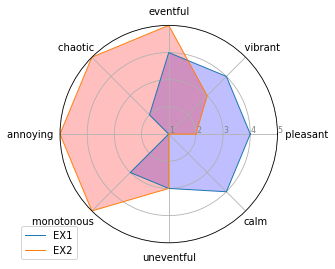

In [3]:
fig = plt.figure(figsize=(4, 4))
plt.rcParams["figure.dpi"] = 350
sample_transform.isd.paq_radar()

Now, we can apply the transform formula from above to calculate the ISOPleasant and ISOEventful values and add them to the dataframe.

In [4]:
sample_transform = sample_transform.isd.add_paq_coords(scale_to_one=True)
sample_transform

,RecordID,pleasant,vibrant,eventful,chaotic,annoying,monotonous,uneventful,calm,ISOPleasant,ISOEventful
RecordID,,,,,,,,,,,
EX1,EX1,4,4,4,2,1,3,3,4,0.53033,0.030330
EX2,EX2,2,3,5,5,5,5,3,1,-0.75000,0.353553


Finally, we can plot these values on a two dimensional plane to visualise how the transform went from the 8 dimensions shown in the radar plot to the two ISO dimensions. This is done by calling the `circumplex_scatter()` function included in `isd.py`. This will create a plotting axis with the appropriate circumplex grid and labels, then plot the ISOPleasant and ISOEventful values as the x and y coordinates.

This treatment of the 8 PAs makes several assumptions and inferences about the relationships between the dimensions. As stated in the standard:

>  According to the two-dimensional model, vibrant soundscapes are both pleasant and eventful, chaotic soundscapes are both eventful and unpleasant, monotonous soundscapes are both unpleasant and uneventful, and finally calm soundscapes are both uneventful and pleasant.

<AxesSubplot:title={'center':'Soundscape Scatter Plot'}, xlabel='ISOPleasant', ylabel='ISOEventful'>

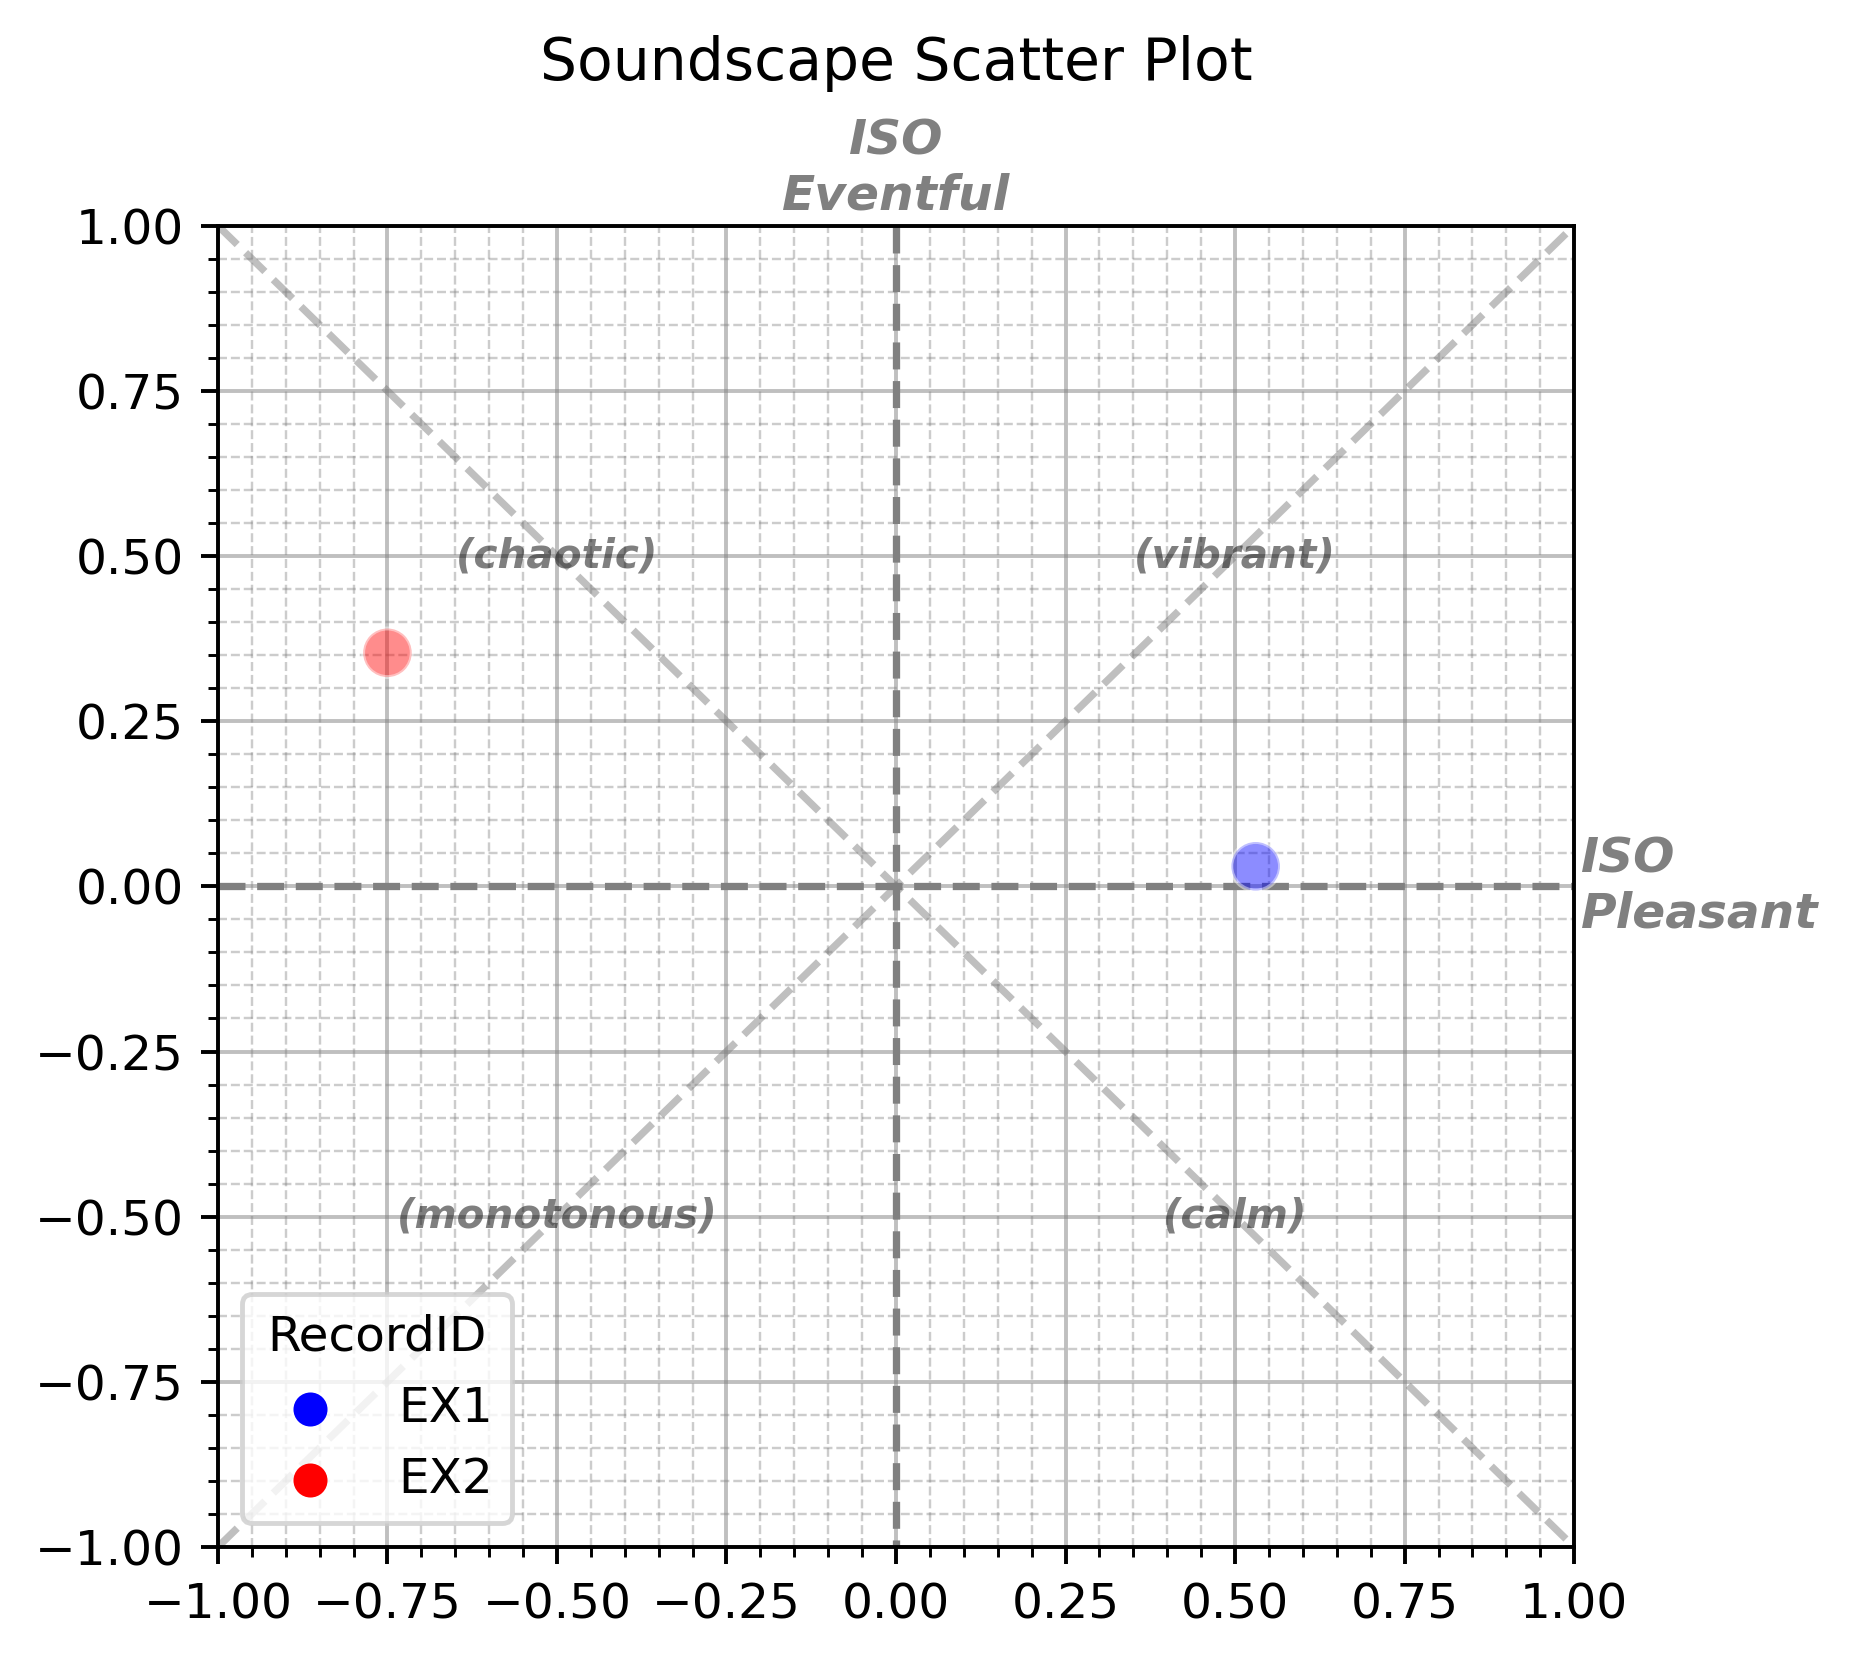

In [5]:
colors=['b', 'r']
palette = sns.color_palette(colors)
sample_transform.isd.circumplex_scatter(hue='RecordID', legend='brief', s=100, palette=palette, alpha=0.45, diagonal_lines=True)

## The way forward: Probabilistic soundscape representation

Given the identified issues with the recommended methods for statistical analysis and their shortcomings in representing the variety in perception of the soundscape in a space, how then should we discuss or present the results of these soundscape assessments? Ideally the method will: 1) take advantage of the circumplex coordinates and their ability to be displayed on a scatter plot and be treated as continuous variables, 2)  scale from a dataset of 10 responses to thousands of responses, 3) facilitate the comparison of the soundscapes of different locations and conditions, and 4) encapsulate the nuances and diversity of soundscape perception by representing the distribution of responses.

We therefore present a series of visualisations of the soundscape assessments of several urban spaces included in the International Soundscape Database (ISD) which reflect these goals. The specific locations selected from the ISD are chosen for demonstration only and these methods can be applied to any location. Rather than attempting to represent a single individual's soundscape or of describing a location's soundscape as a single average assessment (as in Part 3 of the ISO technical specification), this representation shows the whole range of perception of the users of the space. 

To begin, we can load the dataset directly from the ISD:

In [6]:
ssid = isd.load_isd_dataset()
ssid = ssid.isd.validate_dataset(allow_na=True)
ssid.head()

Renaming PAQ columns.
Checking PAQ data quality.
Identified 10 samples to remove.
[168, 190, 204, 222, 308, 557, 1023, 1213, 1851, 1865]


,LocationID,SessionID,GroupID,RecordID,Language,Lockdown,start_time,end_time,latitude,longitude,...,"FS_Avg,arith(vacil)","I_HM_Avg,arith(iu)","Ton_HM_Avg,arith(tuHMS)",LZeq_L(dB(SPL)),LAeq_L(A)(dB(SPL)),LA10_LA90(dB(SPL)),LCeq_LAeq(dB(SPL)),LC10_LC90(dB(SPL)),RA_2D_cp(cPa),PA(Zwicker)
0,CamdenTown,CamdenTown1,CT101,525.0,English,0,2019-05-02 11:40:00,2019-05-02 11:43:00,51.539124,-0.142624,...,0.01700,0.358,0.309,79.72,70.07,7.78,7.81,8.11,14.3,36.019181
1,CamdenTown,CamdenTown1,CT101,561.0,English,0,2019-05-02 11:40:00,2019-05-02 11:43:00,51.539124,-0.142624,...,0.01700,0.358,0.309,79.72,70.07,7.78,7.81,8.11,14.3,36.019181
2,CamdenTown,CamdenTown1,CT101,526.0,English,0,2019-05-02 11:41:00,2019-05-02 11:44:00,51.539124,-0.142624,...,0.01700,0.358,0.309,79.72,70.07,7.78,7.81,8.11,14.3,36.019181
3,CamdenTown,CamdenTown1,CT102,560.0,English,0,2019-05-02 11:50:00,2019-05-02 11:53:00,51.539124,-0.142624,...,0.01790,0.362,0.268,80.27,71.26,8.38,6.25,7.82,14.7,40.523268
4,CamdenTown,CamdenTown1,CT103,527.0,English,0,2019-05-02 11:49:00,2019-05-02 11:54:00,51.539124,-0.142624,...,0.00889,0.370,0.193,76.79,66.71,4.23,7.61,3.99,13.4,27.108635


First, rather than calculating the median response to each PA in the location, then calculating the circumplex coordinates, the coordinates for each individual response are calculated. This results in a vector of ISOPleasant, ISOEventful values which are continuous variables from -1 to +1 and can be analysed statistically by calculating summary statistics (mean, standard deviation, quintiles, etc.) and through the use of regression modelling, which can often be simpler and more familiar than the recommended methods of analysing ordinal data. This also enables each individual's response to be placed within the pleasant-eventful space. All of the responses for a location can then be plotted, giving an overall scatter plot for a location, as demonstrated in (i). 

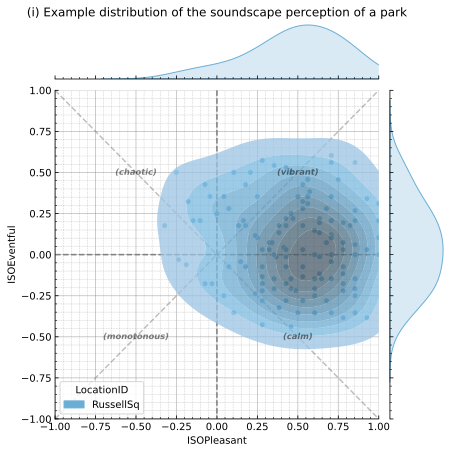

In [12]:
ssid.isd.filter_location_ids(['RussellSq']).isd.circumplex_jointplot_density(
    marginal_kind='kde', 
    title='(i) Example distribution of the soundscape perception of a park', 
    diagonal_lines=True, 
    hue='LocationID',
    legend=True,
    alpha=0.75, 
    palette='Blues', 
    incl_scatter=True,
    joint_kwargs={'s':30}
    )

Once these individual responses are plotted, we then overlay a heatmap of the bivariate distribution (with color maps for each decile) and marginal distribution plots. In this way, three primary characteristics of the soundscape perception can be seen: 

1) The distribution across both pleasantness and eventfulness, including the central tendency, the dispersion, and any skewness in the response;
2) The general shape of the soundscape within the space - in this case Russell Sq is almost entirely in the pleasant half, but is split relatively evenly across the eventfulness space, meaning while it is perceived as generally pleasant, it is not strongly calm or vibrant;
3) The degree of agreement about the soundscape perception - there appears to be a relatively high agreement about the character of Russell Sq, as demonstrated by the compactness of the distribution, but this is not the case for every location, as will be shown later.

Fig (i) includes several in-depth visualisations of the distribution of soundscape assessments, however the detail included can make further analysis difficult. In particular, a decile heatmap is so visually busy that, in our experience, it is not possible to plot more than one soundscape distribution at a time without the figure becoming overly busy. It also can make it difficult to truly grasp point 2, the general shape of the soundscape. To facilitate this, the same soundscape can be represented by its 50th percentile contour, as demonstrated in Fig (ii) where the shaded portion contains 50% of the responses. This simplified view of the distribution presents several advantages, as will be demonstrated in Figs. (iii and iv) and takes inspiration from the recommendation in the ISO standard to use the median as a summary statistic.

When visualised this way, it is possible to identify outliers and responses which are the result of anamolous sound events. For instance if, during a survey session at a calm park, a fleet of helicopters flies overhead, driving the participants to respond that the soundscape is highly chaotic, we would see a group of scatter points in the chaotic quadrant which appear obviously outside the general pattern of responses. In a simpler analysis method, these responses would either be entirely discarded as outliers or surveys and soundwalks would be halted entirely -- ignoring what is in fact a significant impact on that location, its soundscape, and how useful it may be for the community -- or would be included within the statistical analysis, significantly impacting the central tendency and dispersion metrics (i.e. median and range) without consideration for the context. This is the situation shown in Fig (ii) where it is obvious that there is strong agreement that Regents Park Fields is highly pleasant and calm, however we can see numerous responses which assessed it as highly chaotic when a series of military helicopter fly overs drastically changed the sound environment of the space for nearly 20 minutes.

<AxesSubplot:title={'center':'(ii) Median perception contour and \nscatter plot of individual assessments'}, xlabel='ISOPleasant', ylabel='ISOEventful'>

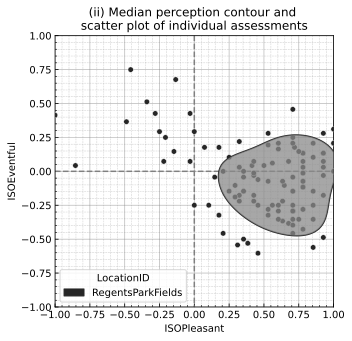

In [13]:
location = 'RegentsParkFields'
ssid.isd.filter_location_ids([location]).isd.circumplex_density(
    title='(ii) Median perception contour and \nscatter plot of individual assessments', 
    hue='LocationID',
    prim_labels=False, 
    fill=True, 
    alpha=0.75, 
    legend=True, 
    thresh=0.50, 
    levels=2, 
    incl_scatter=True, 
    s=30,
    incl_outline=True, 
    fill_color='orange',
    palette='dark:gray'
    )


Fig (iii) demonstrates how this simplified representation makes it possible to compare the soundscape of several locations in a sophisticated way. The soundscape assessments of three urban spaces, Camden Town, Pancras Lock, and Russell Square, are shown overlaid with each other. We can see that Camden Town, a busy and crowded street corner with high levels of traffic noise and amplified music, is generally perceived as chaotic, but the median contour shape which characterises it also crosses over into the vibrant quadrant. We can also see that, for a part of the sample, Russell Square and Pancras Lock are both perceived as similarly pleasant, however some portion of the responses perceived Pancras Lock as being somewhat chaotic and annoying. This kind of visualisation is able to highlight these similarities between the soundscapes in the locations and identify how they differ. From here, further investigation could lead us to answer what is it that led to those people perceiving the location as unpleasant, and what similarities does the soundscape of Pancras Lock have with Russell Square that could perhaps be enhanced to increase the proportion of people perceiving it as more pleasant.

<AxesSubplot:title={'center':'(iii) Comparison of the soundscapes of three urban spaces'}, xlabel='ISOPleasant', ylabel='ISOEventful'>

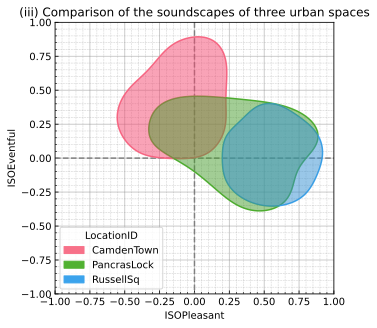

In [14]:
ssid.isd.filter_location_ids(['CamdenTown', 'RussellSq', 'PancrasLock']).isd.circumplex_density(
    title='(iii) Comparison of the soundscapes of three urban spaces', 
    hue='LocationID', 
    prim_labels=False,
    fill=True, 
    alpha = 0.5, 
    palette='husl', 
    thresh=0.5, 
    levels=2, 
    incl_outline=True,
    legend=True)


In addition to solely analysing the distributions of the perceptual responses themselves, this method can also be combined with other acoustic, environmental, and contextual data. The final example, in Fig (iv) demonstrates how this method can better demonstrate the complex relationships between acoustic features of the sound environment and the soundscape perception. The data in the ISD includes approximately 30 second long binaural audio recordings taken while each participant was responding to the soundscape survey, providing an indication of the exact sound environment they were exposed to. For Fig (iv) the entire dataset of 1,338 responses at all 13 locations has been split according to the analysis of these recordings giving a set of less than 65 dB LAeq and  a set of more than 65 dB. The bivariate distribution of these two conditions are then plotted. 

In [15]:
ssid['score'] = ssid['Overall'] + ssid['Appropriate']
ssid['comp_score'] = 'Good'
ssid.loc[ssid['Overall'] < 5, 'comp_score'] = 'Bad'

ssid.head()

,LocationID,SessionID,GroupID,RecordID,Language,Lockdown,start_time,end_time,latitude,longitude,...,"Ton_HM_Avg,arith(tuHMS)",LZeq_L(dB(SPL)),LAeq_L(A)(dB(SPL)),LA10_LA90(dB(SPL)),LCeq_LAeq(dB(SPL)),LC10_LC90(dB(SPL)),RA_2D_cp(cPa),PA(Zwicker),score,comp_score
0,CamdenTown,CamdenTown1,CT101,525.0,English,0,2019-05-02 11:40:00,2019-05-02 11:43:00,51.539124,-0.142624,...,0.309,79.72,70.07,7.78,7.81,8.11,14.3,36.019181,5.0,Bad
1,CamdenTown,CamdenTown1,CT101,561.0,English,0,2019-05-02 11:40:00,2019-05-02 11:43:00,51.539124,-0.142624,...,0.309,79.72,70.07,7.78,7.81,8.11,14.3,36.019181,5.0,Bad
2,CamdenTown,CamdenTown1,CT101,526.0,English,0,2019-05-02 11:41:00,2019-05-02 11:44:00,51.539124,-0.142624,...,0.309,79.72,70.07,7.78,7.81,8.11,14.3,36.019181,7.0,Bad
3,CamdenTown,CamdenTown1,CT102,560.0,English,0,2019-05-02 11:50:00,2019-05-02 11:53:00,51.539124,-0.142624,...,0.268,80.27,71.26,8.38,6.25,7.82,14.7,40.523268,6.0,Bad
4,CamdenTown,CamdenTown1,CT103,527.0,English,0,2019-05-02 11:49:00,2019-05-02 11:54:00,51.539124,-0.142624,...,0.193,76.79,66.71,4.23,7.61,3.99,13.4,27.108635,7.0,Bad


In [8]:
ssid['comp_score'].describe()

count     1899
unique       2
top        Bad
freq      1039
Name: comp_score, dtype: object

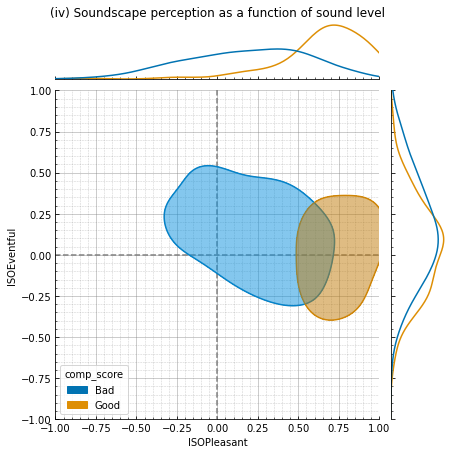

In [9]:
ssid.isd.circumplex_jointplot_density(
    marginal_kind='kde', 
    title='(iv) Soundscape perception as a function of sound level', 
    diagonal_lines=False, 
    alpha=0.5, 
    palette='colorblind', 
    hue='comp_score', 
    legend=True, #
    joint_kwargs={'levels':2, 'thresh': 0.5, 'common_norm': False, 'incl_outline':True},
    marginal_kwargs={'common_norm': False})

count      773
unique       2
top       Good
freq       389
Name: comp_score, dtype: object


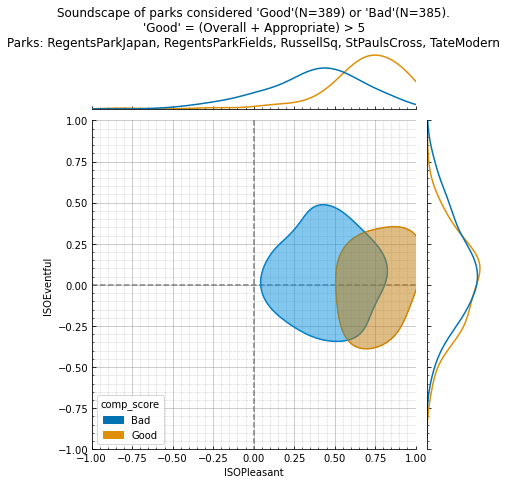

In [10]:
parks = ssid.isd.filter_location_ids(['RegentsParkJapan', 'RegentsParkFields', 'RussellSq', 'StPaulsCross', 'TateModern'])

print(parks['comp_score'].describe())

parks.isd.circumplex_jointplot_density(
    marginal_kind='kde', 
    title="Soundscape of parks considered 'Good'(N=389) or 'Bad'(N=385).\n'Good' = (Overall + Appropriate) > 5\nParks: RegentsParkJapan, RegentsParkFields, RussellSq, StPaulsCross, TateModern" , 
    diagonal_lines=False, 
    alpha=0.5, 
    palette='colorblind', 
    hue='comp_score', 
    legend=True, #
    joint_kwargs={'levels':2, 'thresh': 0.5, 'common_norm': False, 'incl_outline':True},
    marginal_kwargs={'common_norm': False})

In [11]:
ssid.LocationID.unique()

array(['CamdenTown', 'EustonTap', 'MarchmontGarden', 'MonumentoGaribaldi',
       'PancrasLock', 'RegentsParkFields', 'RegentsParkJapan',
       'RussellSq', 'SanMarco', 'StPaulsCross', 'StPaulsRow',
       'TateModern', 'TorringtonSq'], dtype=object)

count     580
unique      2
top       Bad
freq      369
Name: comp_score, dtype: object


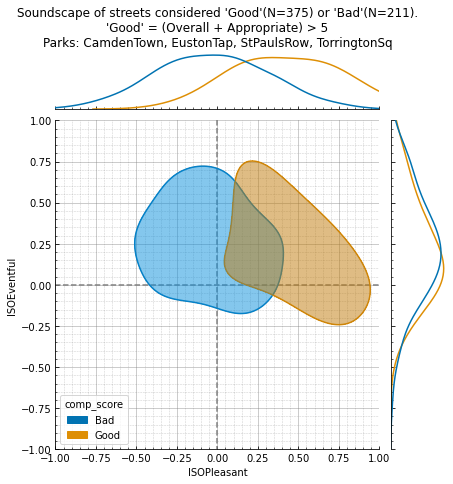

In [12]:
streets = ssid.isd.filter_location_ids(['CamdenTown', 'EustonTap', 'StPaulsRow', 'TorringtonSq'])

print(streets['comp_score'].describe())

streets.isd.circumplex_jointplot_density(
    marginal_kind='kde', 
    title="Soundscape of streets considered 'Good'(N=375) or 'Bad'(N=211).\n'Good' = (Overall + Appropriate) > 5\nParks: CamdenTown, EustonTap, StPaulsRow, TorringtonSq" , 
    diagonal_lines=False, 
    alpha=0.5, 
    palette='colorblind', 
    hue='comp_score', 
    legend=True, #
    joint_kwargs={'levels':2, 'thresh': 0.5, 'common_norm': False, 'incl_outline':True},
    marginal_kwargs={'common_norm': False})

<AxesSubplot:title={'center':'Comparing TorringtonSq to the streets ideal'}, xlabel='ISOPleasant', ylabel='ISOEventful'>

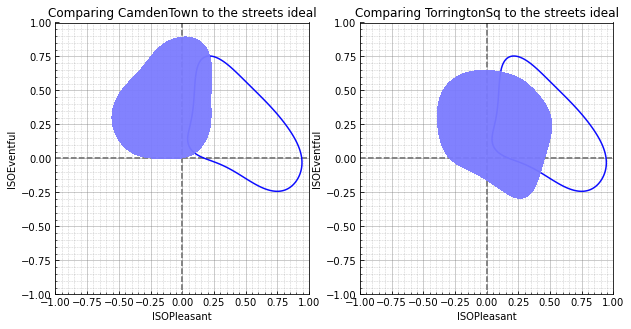

In [13]:
fig, axes = plt.subplots(1,2, figsize=(10,5))
streets.query("comp_score == 'Good'").isd.circumplex_density(
    ax=axes.flatten()[0],
    title='Comparing CamdenTown to the streets ideal',
    prim_labels=False,
    thresh=0.5,
    levels=2,
    fill=False,
    outline_color='orange'
)
ssid.isd.filter_location_ids(['CamdenTown']).isd.circumplex_density(
    ax=axes.flatten()[0],
    title='Comparing CamdenTown to the streets ideal',
    prim_labels=False, thresh=0.5,
    levels=2
)

streets.query("comp_score == 'Good'").isd.circumplex_density(
    ax=axes.flatten()[1],
    title='Comparing TorringtonSq to the streets ideal',
    prim_labels=False,
    thresh=0.5,
    levels=2,
    fill=False,
    outline_color='orange'
)
ssid.isd.filter_location_ids(['TorringtonSq']).isd.circumplex_density(
    ax=axes.flatten()[1],
    title='Comparing TorringtonSq to the streets ideal',
    prim_labels=False, thresh=0.5,
    levels=2
)

## Other examples

In addition to the visualisation demonstrations given above which were included in the JASA Express Letters article, we present a few examples of the uses of this distributional shape approach. 

### The soundscape shape of all 13 locations:

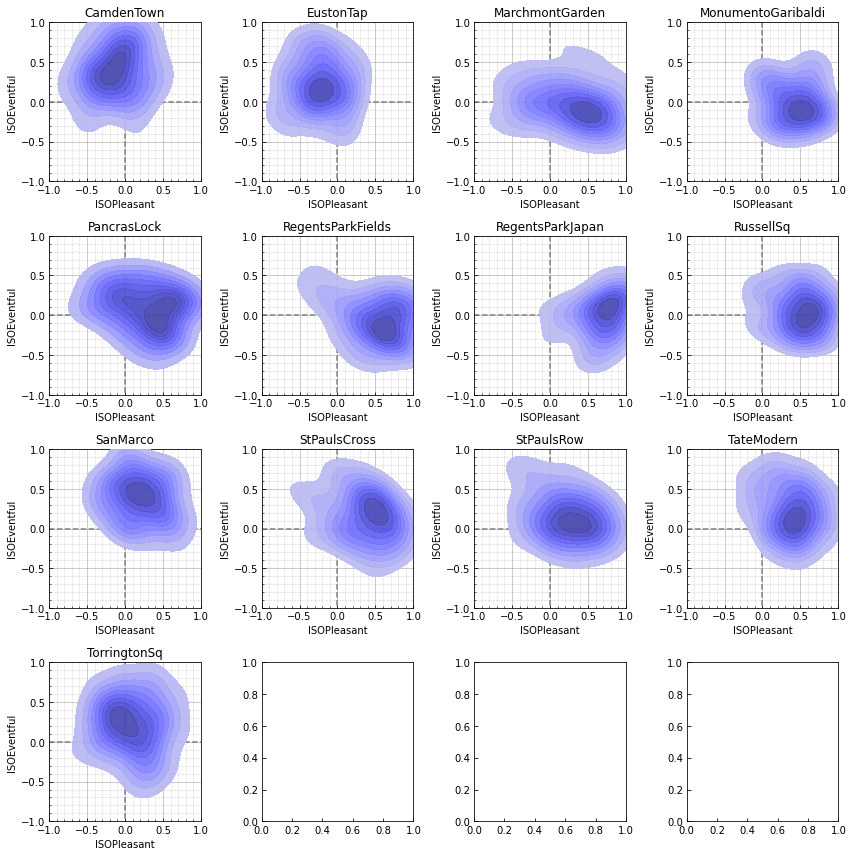

In [14]:
fig, axes = plt.subplots(4, 4, figsize=(12,12))
for i, location in enumerate(ssid.LocationID.unique()):
    ssid.isd.filter_location_ids(location_ids=[location]).isd.circumplex_density(ax=axes.flatten()[i], title=location, prim_labels=False, levels=10, thresh=0.1)

plt.tight_layout()

### A comparison of two days in the same location:

<AxesSubplot:title={'center':'Comparison of two days in Regents Park'}, xlabel='ISOPleasant', ylabel='ISOEventful'>

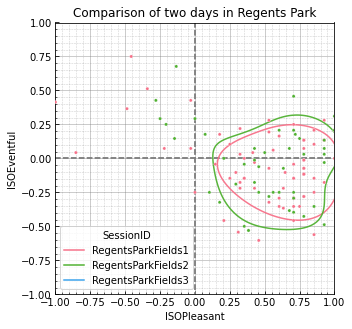

In [15]:
    fig, ax = plt.subplots(1,1,figsize=(5,5))
    location='RegentsParkFields'
    ssid.isd.filter_location_ids(location_ids=[location]).isd.circumplex_density(ax=ax, title='Comparison of two days in Regents Park', prim_labels=False, fill=False, hue='SessionID', palette='husl', legend=True, lw=4, thresh=0.5, levels=2)
    ssid.isd.filter_location_ids(location_ids=[location]).isd.circumplex_scatter(ax=ax, title='Comparison of two days in Regents Park', prim_labels=False, hue="SessionID", palette='husl', s=10)

### All of the survey days in every location:

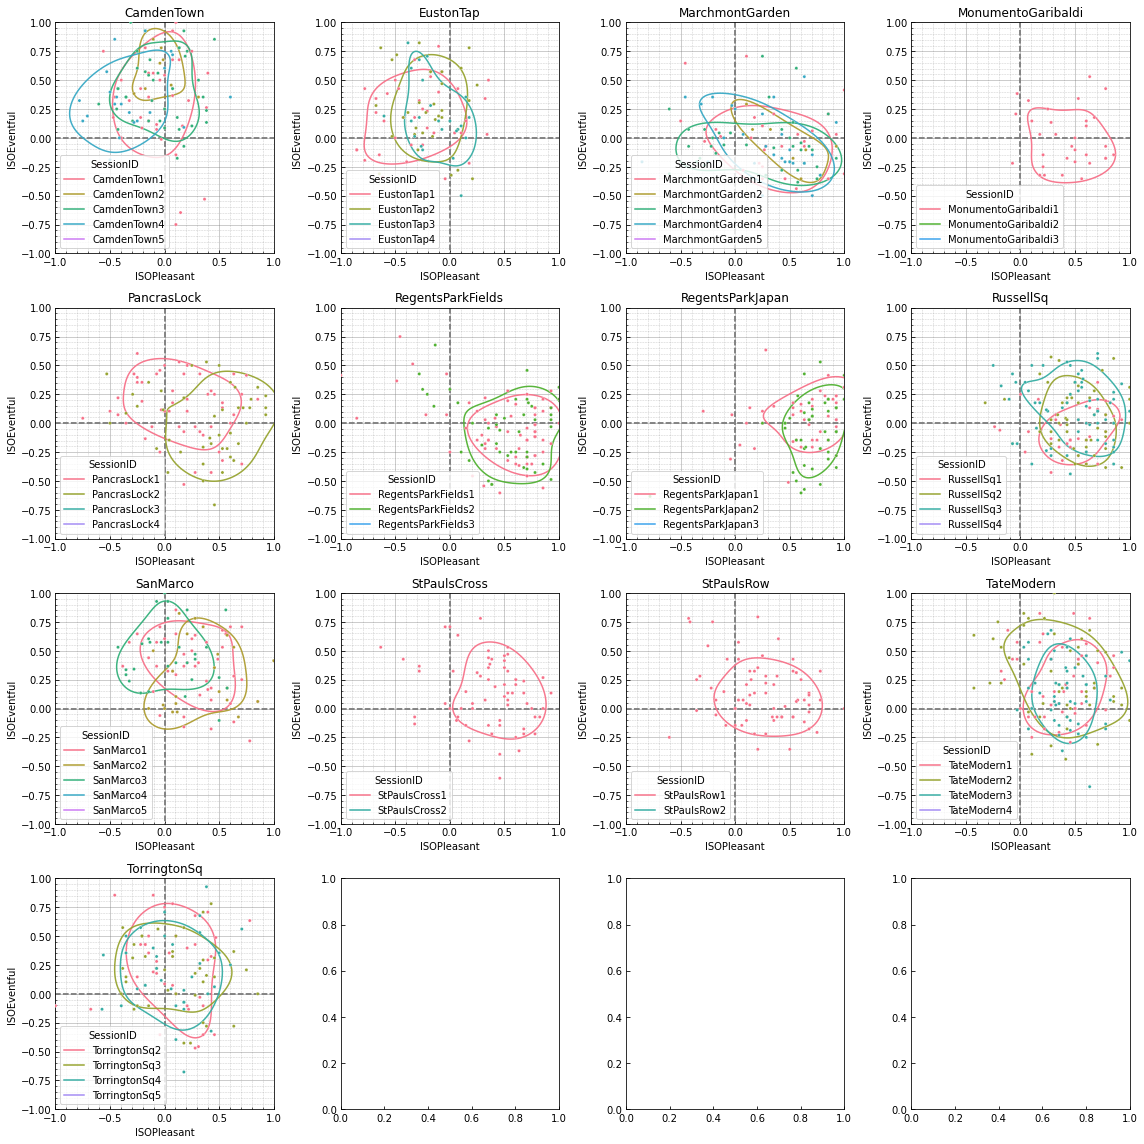

In [16]:
fig, axes = plt.subplots(4, 4, figsize=(16,16))
for i, location in enumerate(ssid['LocationID'].unique()):
    ssid.isd.filter_location_ids(location_ids=[location]).isd.circumplex_density(
        ax=axes.flatten()[i], 
        title=location, 
        prim_labels=False, 
        fill=False, 
        hue='SessionID', 
        palette='husl', 
        legend=True, 
        lw=4, 
        thresh=0.5, 
        levels=2
        )
    ssid.isd.filter_location_ids(location_ids=[location]).isd.circumplex_scatter(
        ax=axes.flatten()[i], 
        title=location, 
        prim_labels=False, 
        hue="SessionID", 
        palette='husl', 
        s=10
        )
plt.tight_layout()

### Statistical analysis of the ISD dataset

Although the visualisations shown in the above figures are a powerful tool for viewing, analysing, and discussing the multi-dimensional aspects of soundscape perception, there are certainly cases where simpler metrics are needed to aid discussion and to set design goals. Taking inspiration from noise annoyance, we propose a move toward discussing the "percent of people likely to perceive" a soundscape as pleasant, vibrant, etc. when it is necessary to use numerical descriptions. In this way, a numerical design goal could also be set as e.g. "the soundscape should be likely to be perceived as pleasant by at least 75% of users" or the results of an intervention presented as e.g. "the likelihood of the soundscape being perceived as calm increased from 30% to 55%". These numbers can be drawn from either actual surveys or from the results of predictive models.

Finally, although acknowledging the distribution of responses is crucial, it is sometimes necessary to summarise locations down to a single point to compare many different locations and to easily investigate how the soundscape assessment has generally changed over time. For this purpose, the mean of the ISOPleasant and ISOEventful values across all respondents is calculated to result in a single coordinate point per location. This clearly mirrors the original intent of the coordinate transformation presented in the ISO, but by applying the transformation first to each individual assessment then calculating the mean value, it maintains a direct link to the distributions shown above. 

We have included a function for creating a numerical summary of each location. For this, we first calculate the mean ISOPleasant and ISOEventful value for the location, giving a single coordinate to describe the location in the circumplex. We then calculate the percentage of overall responses falling in the `pleasant` or `eventful` halfs, or in the `vibrant`, `chaotic`, etc. quadrants.

In [17]:
results = ssid.isd.soundscapy_describe()
results

,count,ISOPleasant,ISOEventful,pleasant,eventful,vibrant,chaotic,monotonous,calm
CamdenTown,150,-0.103,0.364,0.247,0.620,0.207,0.380,0.027,0.040
EustonTap,139,-0.220,0.198,0.173,0.532,0.122,0.403,0.101,0.043
MarchmontGarden,147,0.279,-0.037,0.510,0.265,0.163,0.088,0.082,0.333
MonumentoGaribaldi,85,0.421,-0.007,0.341,0.165,0.141,0.024,0.012,0.188
PancrasLock,176,0.254,0.076,0.375,0.324,0.199,0.114,0.023,0.165
RegentsParkFields,162,0.501,-0.050,0.636,0.302,0.216,0.080,0.000,0.401
RegentsParkJapan,133,0.656,-0.006,0.669,0.368,0.353,0.015,0.015,0.278
RussellSq,190,0.482,0.052,0.711,0.416,0.374,0.037,0.026,0.295
SanMarco,138,0.217,0.372,0.514,0.623,0.449,0.159,0.007,0.065
StPaulsCross,93,0.358,0.139,0.602,0.452,0.376,0.065,0.022,0.183


The standard `describe()` method in pandas can also still be used to calculate other summary statistics.

In [18]:
ssid.describe()

,RecordID,Lockdown,latitude,longitude,Traffic,Other,Human,Natural,ISOPleasant,ISOEventful,...,"I_HM_Avg,arith(iu)","Ton_HM_Avg,arith(tuHMS)",LZeq_L(dB(SPL)),LAeq_L(A)(dB(SPL)),LA10_LA90(dB(SPL)),LCeq_LAeq(dB(SPL)),LC10_LC90(dB(SPL)),RA_2D_cp(cPa),PA(Zwicker),score
count,1292.000000,1899.000000,1292.000000,1292.000000,1291.000000,1291.000000,1291.000000,1291.000000,1292.000000,1292.000000,...,1733.000000,1733.000000,1733.000000,1733.000000,1733.000000,1733.000000,1733.000000,1733.000000,1733.000000,1290.000000
mean,757.020124,0.300685,50.911149,1.128846,2.647560,2.323780,3.110767,2.491092,0.274692,0.132410,...,0.396073,0.199996,72.839331,61.277288,5.994830,8.415176,5.893468,12.308834,22.620181,7.271318
std,912.833521,0.458677,1.832983,3.752524,1.105532,1.142098,0.980097,1.188005,0.406202,0.319232,...,0.078889,0.154636,5.774892,7.638398,3.519796,4.229759,3.114170,2.118526,15.563598,1.656039
min,1.000000,0.000000,45.431837,-0.153024,1.000000,1.000000,1.000000,1.000000,-1.000000,-0.750000,...,0.197000,0.017300,52.990000,42.270000,0.440000,-0.290000,0.520000,7.420000,4.335480,2.000000
25%,334.750000,0.000000,51.514220,-0.132300,2.000000,1.000000,2.000000,2.000000,-0.003150,-0.103600,...,0.340000,0.099100,69.080000,54.950000,3.760000,5.460000,3.580000,10.800000,11.839833,6.000000
50%,698.000000,0.000000,51.523373,-0.126202,3.000000,2.000000,3.000000,2.000000,0.323200,0.116100,...,0.384000,0.160000,73.200000,61.850000,5.430000,8.090000,4.980000,12.200000,18.843209,7.000000
75%,1045.250000,1.000000,51.526900,-0.100162,4.000000,3.000000,4.000000,3.000000,0.603600,0.353600,...,0.433000,0.257000,76.580000,67.090000,7.500000,10.640000,7.540000,13.600000,30.767981,8.000000
max,10018.000000,1.000000,51.539196,12.354908,5.000000,5.000000,5.000000,5.000000,1.000000,1.000000,...,1.110000,1.440000,97.310000,86.310000,22.970000,26.280000,21.960000,33.000000,199.155517,10.000000


Finally, the mean coordinate values for each location can be plotted in the soundscape circumplex.

<AxesSubplot:title={'center':'Soundscape Scatter Plot'}, xlabel='ISOPleasant', ylabel='ISOEventful'>

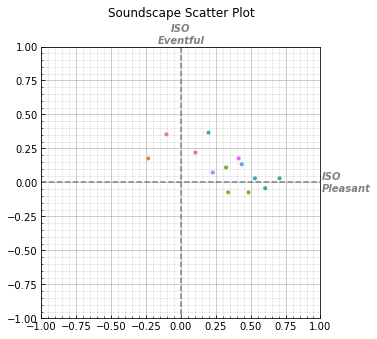

In [19]:
means = ssid.groupby('LocationID').median()
means['LocationID'] = means.index
fig, ax = plt.subplots(1,1,figsize=(5,5))
ax.set_xlim([-.25, .75])
ax.set_ylim([-.25, .75])
means.isd.circumplex_scatter(ax=ax, hue='LocationID', s=20)
